In [1]:
from pybaseball import statcast
from pybaseball import statcast_batter
from pybaseball import team_game_logs
from pybaseball import team_ids
from pybaseball import team_batting
from pybaseball import playerid_reverse_lookup
from pybaseball import standings
from pybaseball import season_game_logs
from pybaseball import schedule_and_record
from pybaseball import cache
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta, datetime
from datetime import date
import pandas as pd

cache.enable()

#Pull in Game Results
year = 2023
teams = ['ATL', 'LAD', 'TEX', 'TBR', 'HOU', 'PHI', 'MIN', 'CHC', 'CIN',
       'TOR', 'BOS', 'SDP', 'STL', 'BAL', 'LAA', 'SEA', 'ARI', 'NYM',
       'MIA', 'COL', 'WSN', 'MIL', 'PIT', 'NYY', 'SFG', 'KCR', 'CLE',
       'DET', 'OAK', 'CHW']
i = 0

game_results = pd.DataFrame([])

while i < len(teams):
    game_results = pd.concat([game_results, schedule_and_record(year,teams[i])])
    i = i + 1
    
game_results['Date'] = game_results['Date'].str.replace(' \(1\)', '').str.replace(' \(2\)', '').str.replace(' \(3\)', '')
game_results['Date'] += " 2023"

import pandas as pd
from datetime import datetime

# Define a function to convert date strings to the desired format
def convert_date(date_str):
    date_object = datetime.strptime(date_str, "%A, %b %d %Y")
    return date_object.strftime("%Y-%m-%d")

# Apply the function to the entire column
game_results['Date'] = game_results['Date'].apply(convert_date)

game_results['Date'] = pd.to_datetime(game_results['Date'])

#Batting Vlookup
vlookupbat = [['strikeout',1,1,0,0,0,0,0,0,0,1],['field_out',1,1,0,0,0,0,0,0,0,0],['single',1,1,1,1,0,0,0,0,0,0],['sac_fly',1,0,0,0,0,0,0,0,0,0],
           ['walk',1,0,0,1,1,0,0,0,0,0],['force_out',1,1,0,0,0,0,0,0,0,0],['double',1,1,1,2,0,0,0,0,0,0],['home_run',1,1,1,4,0,0,0,1,0,0],['triple',1,1,1,3,0,0,0,0,0,0],
           ['grounded_into_double_play',1,1,0,0,0,0,0,0,1,0],['hit_by_pitch',1,0,0,1,0,0,0,0,0,0],['strikeout_double_play',1,1,0,0,0,0,0,0,1,1],
           ['fielders_choice',1,1,0,0,0,0,0,0,0,0],['fielders_choice_out',1,1,0,0,0,0,0,0,0,0],['sac_bunt',1,0,0,0,0,0,0,0,0,0],['catcher_interf',1,0,0,1,0,0,0,0,0,0],
           ['field_error',1,1,0,1,0,0,0,0,0,0],['caught_stealing_2b',0,0,0,0,0,0,1,0,0,0],['pickoff_caught_stealing_2b',0,0,0,0,0,0,1,0,0,0],['sac_fly_double_play',1,1,0,0,0,0,0,0,1,0],
           ['pickoff_2b',0,0,0,0,0,0,1,0,0,0],['pickoff_1b',0,0,0,0,0,0,1,0,0,0],['pickoff_3b',0,0,0,0,0,0,1,0,0,0],['caught_stealing_3b',0,0,0,0,0,0,1,0,0,0],['caught_stealing_home',0,0,0,0,0,0,1,0,0,0],
           ['pickoff_caught_stealing_3b',0,0,0,0,0,0,1,0,0,0],['pickoff_caught_stealing_home',0,0,0,0,0,0,1,0,0,0],['double_play',1,1,0,0,0,0,0,0,1,0],['triple_play',1,1,0,0,0,0,0,0,2,0],
           ['other_out',1,1,0,0,0,0,0,0,0,0],['stolen_base_2b',0,0,0,0,0,1,0,0,0,0],['stolen_base_3b',0,0,0,0,0,1,0,0,0,0],['stolen_base_home',0,0,0,0,0,1,0,0,0,0],['wild_pitch',0,0,0,0,0,1,0,0,0,0]]
           
vlbat = pd.DataFrame(vlookupbat,columns=['events','PA','AB','H','TB','BB','SB','CS','HR','GIDP','SO'])

#Pitching Vlookup
vlookuppit = [['swinging_strike',1,0],['foul',1,0],['called_strike',1,0],['hit_into_play',1,0],['foul_tip',1,0],
             ['swinging_strike_blocked',1,0],['foul_bunt',1,0],['missed_bunt',1,0],['foul_bunt_tip',1,0],
             ['ball',0,1],['blocked_ball',0,1],['hit_by_pitch',0,1],['pitchout',0,1],]
           
vlpit = pd.DataFrame(vlookuppit,columns=['description','strike','ball'])


day_delta=timedelta(days=1)
end_date = pd.to_datetime(date(2023,9,30))
start_date = end_date - 18*day_delta  #185
df = pd.DataFrame([])

for i in range((end_date - start_date).days):
    end = start_date + i*day_delta
    start = end - 14*day_delta
    pred = end + i*day_delta
    
    data = statcast(start.strftime("%Y-%m-%d"),end.strftime("%Y-%m-%d"))
    
    #Adding Pitcher Team
    data['Opp'] = data['away_team'].where(data['inning_topbot'] == "Bot", data['home_team'])

    #Adding Batter Team
    data['Tm'] = data['away_team'].where(data['inning_topbot'] == "Top", data['home_team'])

    #Converting Player Name to Pitcher Name
    #Adding Batter Team
    data = data.rename(columns={'player_name':'pitcher_name'})
    
    #Creation of batting/pitching specific data frames
    batting_data = data.dropna(subset = 'events')
    batting_data['hit_distance_sc'] = pd.to_numeric(batting_data['hit_distance_sc'],errors = 'ignore', downcast = 'float')
    batting_data = batting_data.dropna(subset = 'hit_distance_sc')  #this line of code is excluding needed data
    batting = pd.merge(data,vlbat,how="left", on=["events"])
    
    pitching_data = data
    pitching = pd.merge(pitching_data,vlpit,how="left", on=["description"])
    pitching['effective_speed'] = pd.to_numeric(pitching['effective_speed'],errors = 'ignore', downcast = 'float')
    pitching['release_spin_rate'] = pd.to_numeric(pitching['release_spin_rate'],errors = 'ignore', downcast = 'float')
    pitching['release_extension'] = pd.to_numeric(pitching['release_extension'],errors = 'ignore', downcast = 'float')
    
    dfr = game_results[game_results['Date'].between(pred,pred)]
    
    ##Create pivot tables and merge on team/opponent
    
    pivotTeamAvg = batting_data.pivot_table(index=batting_data['Tm'],
                        values = ['hit_distance_sc','launch_speed'],
                        aggfunc = 'mean')
    pivotTeamSum = batting.pivot_table(index=batting['Tm'],
                        values = ['PA','AB','H','TB','BB','SB','CS','HR','GIDP','SO'],
                        aggfunc = ['sum'])
    dfta = pivotTeamAvg.reset_index()
    dfts = pivotTeamSum.reset_index()
    dftsa = pd.merge(dfta,dfts, on='Tm')
    
    pivotPitAvg = pitching.pivot_table(index=pitching['Opp'],
                        values = ['effective_speed','release_spin_rate','release_extension'],
                        aggfunc = 'mean')
    pivotPitSum = pitching.pivot_table(index=pitching['Opp'],
                        values = ['strike','ball'],
                        aggfunc = ['sum'])
    dfpa = pivotPitAvg.reset_index()
    dfps = pivotPitSum.reset_index()
    dfpsa = pd.merge(dfpa,dfps, on=["Opp"])
    #add to df
    
    dftt = pd.merge(dfr,dftsa,on='Tm')
    
    dft = pd.merge(dftt,dfpsa,on='Opp')
    
    df = pd.concat([df, dft])

df

http://www.baseball-reference.com/teams/ATL/2023-schedule-scores.shtml
http://www.baseball-reference.com/teams/LAD/2023-schedule-scores.shtml
http://www.baseball-reference.com/teams/TEX/2023-schedule-scores.shtml
http://www.baseball-reference.com/teams/TBR/2023-schedule-scores.shtml
http://www.baseball-reference.com/teams/HOU/2023-schedule-scores.shtml
http://www.baseball-reference.com/teams/PHI/2023-schedule-scores.shtml
http://www.baseball-reference.com/teams/MIN/2023-schedule-scores.shtml
http://www.baseball-reference.com/teams/CHC/2023-schedule-scores.shtml
http://www.baseball-reference.com/teams/CIN/2023-schedule-scores.shtml
http://www.baseball-reference.com/teams/TOR/2023-schedule-scores.shtml
http://www.baseball-reference.com/teams/BOS/2023-schedule-scores.shtml
http://www.baseball-reference.com/teams/SDP/2023-schedule-scores.shtml
http://www.baseball-reference.com/teams/STL/2023-schedule-scores.shtml
http://www.baseball-reference.com/teams/BAL/2023-schedule-scores.shtml
http:/

C:\Users\apath\AppData\Local\Temp\ipykernel_14128\2735897789.py:34: FutureWarning: The default value of regex will change from True to False in a future version.
  game_results['Date'] = game_results['Date'].str.replace(' \(1\)', '').str.replace(' \(2\)', '').str.replace(' \(3\)', '')
100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.51it/s]
C:\Users\apath\AppData\Local\Temp\ipykernel_14128\2735897789.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batting_data['hit_distance_sc'] = pd.to_numeric(batting_data['hit_distance_sc'],errors = 'ignore', downcast = 'float')
C:\Users\apath\AppData\Local\Temp\ipykernel_14128\2735897789.py:116: FutureWarning: merging between different levels 

This is a large query, it may take a moment to complete


C:\Users\apath\AppData\Local\Temp\ipykernel_14128\2735897789.py:126: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  dfpsa = pd.merge(dfpa,dfps, on=["Opp"])
100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  6.15it/s]
C:\Users\apath\AppData\Local\Temp\ipykernel_14128\2735897789.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batting_data['hit_distance_sc'] = pd.to_numeric(batting_data['hit_distance_sc'],errors = 'ignore', downcast = 'float')
C:\Users\apath\AppData\Local\Temp\ipykernel_14128\2735897789.py:116: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels 

This is a large query, it may take a moment to complete


C:\Users\apath\AppData\Local\Temp\ipykernel_14128\2735897789.py:126: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  dfpsa = pd.merge(dfpa,dfps, on=["Opp"])
100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  6.44it/s]


This is a large query, it may take a moment to complete


C:\Users\apath\AppData\Local\Temp\ipykernel_14128\2735897789.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batting_data['hit_distance_sc'] = pd.to_numeric(batting_data['hit_distance_sc'],errors = 'ignore', downcast = 'float')
C:\Users\apath\AppData\Local\Temp\ipykernel_14128\2735897789.py:116: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  dftsa = pd.merge(dfta,dfts, on='Tm')
C:\Users\apath\AppData\Local\Temp\ipykernel_14128\2735897789.py:116: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  dftsa = pd.merge(dfta,dfts, on='Tm')
C:\Users\apath\AppData\Local\Temp\ipykernel_14128\27358

This is a large query, it may take a moment to complete


C:\Users\apath\AppData\Local\Temp\ipykernel_14128\2735897789.py:116: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  dftsa = pd.merge(dfta,dfts, on='Tm')
C:\Users\apath\AppData\Local\Temp\ipykernel_14128\2735897789.py:126: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  dfpsa = pd.merge(dfpa,dfps, on=["Opp"])
C:\Users\apath\AppData\Local\Temp\ipykernel_14128\2735897789.py:126: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  dfpsa = pd.merge(dfpa,dfps, on=["Opp"])
100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.91it/s]
C:\Users\apath\AppData\Local\Temp\ipykernel_14128\2735897789.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

This is a large query, it may take a moment to complete


C:\Users\apath\AppData\Local\Temp\ipykernel_14128\2735897789.py:126: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  dfpsa = pd.merge(dfpa,dfps, on=["Opp"])
100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  6.26it/s]
C:\Users\apath\AppData\Local\Temp\ipykernel_14128\2735897789.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batting_data['hit_distance_sc'] = pd.to_numeric(batting_data['hit_distance_sc'],errors = 'ignore', downcast = 'float')
C:\Users\apath\AppData\Local\Temp\ipykernel_14128\2735897789.py:116: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels 

This is a large query, it may take a moment to complete


C:\Users\apath\AppData\Local\Temp\ipykernel_14128\2735897789.py:126: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  dfpsa = pd.merge(dfpa,dfps, on=["Opp"])
C:\Users\apath\AppData\Local\Temp\ipykernel_14128\2735897789.py:126: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  dfpsa = pd.merge(dfpa,dfps, on=["Opp"])
100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  6.32it/s]
C:\Users\apath\AppData\Local\Temp\ipykernel_14128\2735897789.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batting_data['hit_distance_sc'] = pd.to_numeric(

This is a large query, it may take a moment to complete


C:\Users\apath\AppData\Local\Temp\ipykernel_14128\2735897789.py:126: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  dfpsa = pd.merge(dfpa,dfps, on=["Opp"])
100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.98it/s]
C:\Users\apath\AppData\Local\Temp\ipykernel_14128\2735897789.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batting_data['hit_distance_sc'] = pd.to_numeric(batting_data['hit_distance_sc'],errors = 'ignore', downcast = 'float')
C:\Users\apath\AppData\Local\Temp\ipykernel_14128\2735897789.py:116: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels 

This is a large query, it may take a moment to complete


C:\Users\apath\AppData\Local\Temp\ipykernel_14128\2735897789.py:126: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  dfpsa = pd.merge(dfpa,dfps, on=["Opp"])
100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  6.35it/s]
C:\Users\apath\AppData\Local\Temp\ipykernel_14128\2735897789.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batting_data['hit_distance_sc'] = pd.to_numeric(batting_data['hit_distance_sc'],errors = 'ignore', downcast = 'float')
C:\Users\apath\AppData\Local\Temp\ipykernel_14128\2735897789.py:116: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels 

This is a large query, it may take a moment to complete


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.71it/s]
C:\Users\apath\AppData\Local\Temp\ipykernel_14128\2735897789.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batting_data['hit_distance_sc'] = pd.to_numeric(batting_data['hit_distance_sc'],errors = 'ignore', downcast = 'float')
C:\Users\apath\AppData\Local\Temp\ipykernel_14128\2735897789.py:116: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  dftsa = pd.merge(dfta,dfts, on='Tm')
C:\Users\apath\AppData\Local\Temp\ipykernel_14128\2735897789.py:116: PerformanceWarning: dropping on a non-lexsorted multi-index without a level paramete

This is a large query, it may take a moment to complete


C:\Users\apath\AppData\Local\Temp\ipykernel_14128\2735897789.py:126: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  dfpsa = pd.merge(dfpa,dfps, on=["Opp"])
100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  6.15it/s]


This is a large query, it may take a moment to complete


C:\Users\apath\AppData\Local\Temp\ipykernel_14128\2735897789.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batting_data['hit_distance_sc'] = pd.to_numeric(batting_data['hit_distance_sc'],errors = 'ignore', downcast = 'float')
C:\Users\apath\AppData\Local\Temp\ipykernel_14128\2735897789.py:116: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  dftsa = pd.merge(dfta,dfts, on='Tm')
C:\Users\apath\AppData\Local\Temp\ipykernel_14128\2735897789.py:116: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  dftsa = pd.merge(dfta,dfts, on='Tm')
C:\Users\apath\AppData\Local\Temp\ipykernel_14128\27358

This is a large query, it may take a moment to complete


C:\Users\apath\AppData\Local\Temp\ipykernel_14128\2735897789.py:116: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  dftsa = pd.merge(dfta,dfts, on='Tm')
C:\Users\apath\AppData\Local\Temp\ipykernel_14128\2735897789.py:126: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  dfpsa = pd.merge(dfpa,dfps, on=["Opp"])
C:\Users\apath\AppData\Local\Temp\ipykernel_14128\2735897789.py:126: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  dfpsa = pd.merge(dfpa,dfps, on=["Opp"])
100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.69it/s]
C:\Users\apath\AppData\Local\Temp\ipykernel_14128\2735897789.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

This is a large query, it may take a moment to complete


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.91it/s]
C:\Users\apath\AppData\Local\Temp\ipykernel_14128\2735897789.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batting_data['hit_distance_sc'] = pd.to_numeric(batting_data['hit_distance_sc'],errors = 'ignore', downcast = 'float')
C:\Users\apath\AppData\Local\Temp\ipykernel_14128\2735897789.py:116: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  dftsa = pd.merge(dfta,dfts, on='Tm')
C:\Users\apath\AppData\Local\Temp\ipykernel_14128\2735897789.py:116: PerformanceWarning: dropping on a non-lexsorted multi-index without a level paramete

This is a large query, it may take a moment to complete


C:\Users\apath\AppData\Local\Temp\ipykernel_14128\2735897789.py:126: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  dfpsa = pd.merge(dfpa,dfps, on=["Opp"])
100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  6.33it/s]


This is a large query, it may take a moment to complete


C:\Users\apath\AppData\Local\Temp\ipykernel_14128\2735897789.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batting_data['hit_distance_sc'] = pd.to_numeric(batting_data['hit_distance_sc'],errors = 'ignore', downcast = 'float')
C:\Users\apath\AppData\Local\Temp\ipykernel_14128\2735897789.py:116: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  dftsa = pd.merge(dfta,dfts, on='Tm')
C:\Users\apath\AppData\Local\Temp\ipykernel_14128\2735897789.py:116: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  dftsa = pd.merge(dfta,dfts, on='Tm')
C:\Users\apath\AppData\Local\Temp\ipykernel_14128\27358

This is a large query, it may take a moment to complete


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.98it/s]
C:\Users\apath\AppData\Local\Temp\ipykernel_14128\2735897789.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batting_data['hit_distance_sc'] = pd.to_numeric(batting_data['hit_distance_sc'],errors = 'ignore', downcast = 'float')
C:\Users\apath\AppData\Local\Temp\ipykernel_14128\2735897789.py:116: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  dftsa = pd.merge(dfta,dfts, on='Tm')
C:\Users\apath\AppData\Local\Temp\ipykernel_14128\2735897789.py:116: PerformanceWarning: dropping on a non-lexsorted multi-index without a level paramete

This is a large query, it may take a moment to complete


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  6.37it/s]
C:\Users\apath\AppData\Local\Temp\ipykernel_14128\2735897789.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batting_data['hit_distance_sc'] = pd.to_numeric(batting_data['hit_distance_sc'],errors = 'ignore', downcast = 'float')
C:\Users\apath\AppData\Local\Temp\ipykernel_14128\2735897789.py:116: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  dftsa = pd.merge(dfta,dfts, on='Tm')
C:\Users\apath\AppData\Local\Temp\ipykernel_14128\2735897789.py:116: PerformanceWarning: dropping on a non-lexsorted multi-index without a level paramete

,Date,Tm,Home_Away,Opp,W/L,R,RA,Inn,W-L,Rank,...,"(sum, HR)","(sum, PA)","(sum, SB)","(sum, SO)","(sum, TB)",effective_speed,release_extension,release_spin_rate,"(sum, ball)","(sum, strike)"
0,2023-09-12,ATL,@,PHI,W,7.0,6.0,10.0,95-50,1.0,...,35.0,591.0,0.0,94.0,333.0,91.183739,6.526577,2268.360107,783.0,1388.0
1,2023-09-12,TEX,@,TOR,W,6.0,3.0,9.0,80-64,2.0,...,21.0,497.0,0.0,97.0,253.0,88.303833,6.548164,2211.011963,643.0,1209.0
2,2023-09-12,HOU,Home,OAK,L,2.0,6.0,9.0,82-64,1.0,...,23.0,505.0,0.0,77.0,277.0,89.267517,6.419786,2192.248047,765.0,1196.0
3,2023-09-12,PHI,Home,ATL,L,6.0,7.0,10.0,79-66,2.0,...,30.0,558.0,0.0,137.0,315.0,88.760666,6.346927,2310.687012,821.0,1457.0
4,2023-09-12,CHC,@,COL,L,4.0,6.0,9.0,78-68,2.0,...,17.0,553.0,0.0,109.0,264.0,88.977669,6.265431,2225.775635,736.0,1234.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,2023-09-30,MIL,Home,CHC,L,6.0,10.0,9.0,91-70,1.0,...,15.0,549.0,0.0,118.0,272.0,88.199394,6.293883,2248.127441,729.0,1249.0
16,2023-09-30,PIT,Home,MIA,L,3.0,7.0,9.0,75-86,4.0,...,14.0,479.0,0.0,130.0,220.0,89.55764,6.39843,2273.378662,784.0,1383.0
17,2023-09-30,CLE,@,DET,L,0.0,8.0,9.0,76-85,3.0,...,11.0,543.0,0.0,90.0,252.0,89.787254,6.344805,2154.813721,721.0,1281.0
18,2023-09-30,DET,Home,CLE,W,8.0,0.0,9.0,77-84,2.0,...,16.0,538.0,0.0,137.0,240.0,88.486664,6.561976,2098.373047,711.0,1343.0


In [4]:
import matplotlib.pyplot as plt

plt.plot(df['Date'], df['R'], label='Runs')
#plt.plot(df['Date'], df['effective_speed'], label='Exit Velocity')
plt.xlabel('Date')
plt.ylabel('Offensive Production')
plt.title('Output')
plt.legend()
plt.show()

KeyError: ('Date', 'Tm')

In [ ]:
teams = ['ATL', 'LAD', 'TEX', 'TBR', 'HOU', 'PHI', 'MIN', 'CHC', 'CIN',
       'TOR', 'BOS', 'SDP', 'STL', 'BAL', 'LAA', 'SEA', 'ARI', 'NYM',
       'MIA', 'COL', 'WSN', 'MIL', 'PIT', 'NYY', 'SFG', 'KCR', 'CLE',
       'DET', 'OAK', 'CHW']
i = 0

game_results = pd.DataFrame([])

while i < len(teams):
    game_results = pd.concat([game_results, schedule_and_record(year,teams[i])])
    i = i + 1

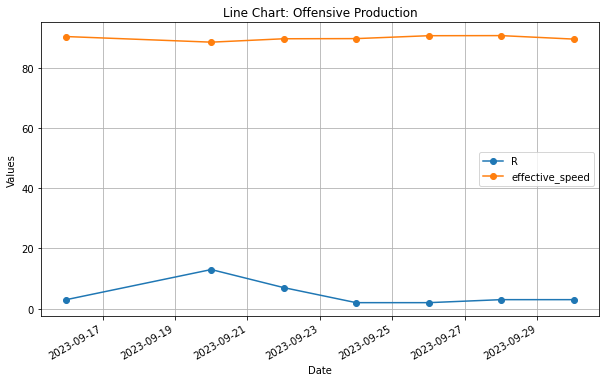

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

df.loc[df['Tm'] == 'PIT'].plot(x='Date', y=['R', 'effective_speed',''], marker='o', linestyle='-', figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Line Chart: Offensive Production')
plt.grid(True)
plt.legend()
plt.show()


In [18]:
df.to_csv(r'C:\Users\apath\Documents\MLB Logistic Regression\statcastapi_preprocessed1.csv')

In [25]:
df.columns.values.tolist()

['Date',
 'Home_Away',
 'W/L',
 'R',
 'RA',
 'Inn',
 'W-L',
 'Rank',
 'GB',
 'Win',
 'Loss',
 'Save',
 'Time',
 'D/N',
 'Attendance',
 'cLI',
 'Streak',
 'Orig. Scheduled',
 'Tm',
 'hit_distance_sc',
 'launch_speed',
 ('sum', 'AB'),
 ('sum', 'BB'),
 ('sum', 'CS'),
 ('sum', 'GIDP'),
 ('sum', 'H'),
 ('sum', 'HR'),
 ('sum', 'PA'),
 ('sum', 'SB'),
 ('sum', 'SO'),
 ('sum', 'TB'),
 'Opp',
 'effective_speed',
 'release_extension',
 'release_spin_rate',
 ('sum', 'ball'),
 ('sum', 'strike')]

In [26]:
X = df[[ 'hit_distance_sc',
 'launch_speed',
 ('sum', 'AB'),
 ('sum', 'BB'),
 ('sum', 'CS'),
 ('sum', 'GIDP'),
 ('sum', 'H'),
 ('sum', 'HR'),
 ('sum', 'PA'),
 ('sum', 'SO'),
 ('sum', 'TB'),
 'effective_speed',
 'release_extension',
 'release_spin_rate',
 ('sum', 'ball'),
 ('sum', 'strike')]]
Y = df['R']

C:\Users\apath\anaconda3\lib\site-packages\pandas\core\common.py:241: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=1)

print(X_train.shape, X_test.shape)

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

model = Ridge(alpha=4.3) # Create a Ridge regression model with alpha=0.5
model.fit(X_train, Y_train) # Train the model on the train set
Y_pred = model.predict(X_test) # Use the model to predict the labels on the test set
print(mean_squared_error(Y_test, Y_pred))

(1116, 16) (280, 16)
10.18941605489046


C:\Users\apath\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\apath\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\apath\anaconda3\lib\site-packages\sklearn\base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)


In [28]:
Y_pred

array([5.01697807, 4.73678724, 5.06746156, 4.95172417, 4.25949772,
       4.09637651, 4.64034685, 4.51452928, 3.97794683, 3.72036228,
       4.35246571, 5.37431091, 4.07379315, 5.20234643, 7.22892559,
       4.14602156, 5.04748954, 6.21162515, 5.18866599, 5.04914896,
       4.75865847, 4.58344596, 4.60844856, 3.68474883, 4.12738499,
       4.4991023 , 3.0756666 , 3.70071293, 3.57504504, 5.13158386,
       4.90986727, 3.8971688 , 4.72009533, 3.85458219, 5.59635239,
       4.57668134, 4.15728666, 4.78737062, 3.53618795, 4.60922711,
       2.43639412, 4.3136276 , 5.32782289, 3.38592843, 4.30495629,
       5.12623091, 4.53578228, 5.13421411, 3.76726035, 3.79887139,
       4.38045219, 4.75945971, 4.87395761, 3.80052596, 4.89049066,
       5.04228279, 4.53450136, 4.4842322 , 4.88972702, 3.94643736,
       4.06879388, 5.23158765, 4.66659053, 4.90929009, 5.11700707,
       3.25401325, 4.55949266, 4.93002274, 4.66401446, 4.26959852,
       4.57162091, 4.51611693, 3.69011575, 5.02115033, 4.43680

In [30]:
X_test

,hit_distance_sc,launch_speed,"(sum, AB)","(sum, BB)","(sum, CS)","(sum, GIDP)","(sum, H)","(sum, HR)","(sum, PA)","(sum, SO)","(sum, TB)",effective_speed,release_extension,release_spin_rate,"(sum, ball)","(sum, strike)"
4,192.037155,90.640373,438.0,42.0,2.0,9.0,111.0,17.0,488.0,120.0,230.0,88.429268,6.559971,2201.01416,736.0,1321.0
0,192.116623,89.332945,435.0,51.0,2.0,5.0,91.0,20.0,494.0,96.0,244.0,88.211578,6.206343,2213.618164,727.0,1354.0
3,167.343643,89.360825,423.0,56.0,0.0,6.0,93.0,17.0,487.0,136.0,224.0,88.509819,6.492731,2313.535645,849.0,1462.0
12,156.731186,90.009164,475.0,51.0,1.0,12.0,127.0,16.0,542.0,111.0,280.0,90.409889,6.406467,2225.304443,650.0,1190.0
10,156.836365,87.577812,453.0,44.0,0.0,16.0,107.0,18.0,507.0,127.0,227.0,88.381912,6.221893,2293.656006,674.0,1250.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,176.409088,88.500267,475.0,48.0,2.0,15.0,124.0,21.0,538.0,108.0,281.0,88.693649,6.216908,2289.151611,702.0,1297.0
15,147.39119,86.682873,454.0,60.0,1.0,11.0,109.0,7.0,527.0,98.0,232.0,88.590446,6.603016,2228.406494,686.0,1250.0
9,155.877914,87.343895,453.0,52.0,2.0,8.0,109.0,10.0,523.0,115.0,231.0,88.338066,6.245953,2276.91748,721.0,1307.0
7,184.910446,90.247006,443.0,47.0,1.0,17.0,125.0,26.0,497.0,110.0,289.0,88.77298,6.356888,2228.396973,718.0,1300.0
